In [2]:
# The core tools for time series forecasting.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

plt.style.use('dark_background')


In [3]:
#importing dataset
df = pd.read_csv('mock_kaggle.csv')
df.head()

,data,venda,estoque,preco
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29


In [4]:
# - Renaming columns to Prophet-friendly names ('ds','y')
# - Converting dates to datetime format
# - Sorting data chronologically (required for forecasting)
# - Resetting index to avoid confusion

df.columns = ['ds','y','inventory','price']
df['ds'] = pd.to_datetime(df['ds'])
df = df.sort_values('ds').reset_index(drop=True)

df.head()


,ds,y,inventory,price
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29


In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Time series MUST have continuous dates.
# - reindexing  to daily frequency
# - filling the missing inventory/price (forward fill)
# - filling the  missing sales with 0 (stockouts or zero-sales days)

df = df.set_index('ds').asfreq('D')
df['inventory'] = df['inventory'].fillna(method='ffill')
df['price'] = df['price'].fillna(method='ffill')
df['y'] = df['y'].fillna(0)

df = df.reset_index()
df.head()


,ds,y,inventory,price
0,2014-01-01,0.0,4972.0,1.29
1,2014-01-02,70.0,4902.0,1.29
2,2014-01-03,59.0,4843.0,1.29
3,2014-01-04,93.0,4750.0,1.29
4,2014-01-05,96.0,4654.0,1.29


In [7]:
# The descriptive insight into data distribution.

df.describe()


,ds,y,inventory,price
count,943,943.000000,943.000000,943.000000
mean,2015-04-17 00:00:00.000000256,89.957582,1619.854719,1.590223
min,2014-01-01 00:00:00,0.000000,0.000000,0.000000
25%,2014-08-24 12:00:00,31.500000,794.000000,1.290000
50%,2015-04-17 00:00:00,75.000000,1356.000000,1.390000
75%,2015-12-08 12:00:00,127.000000,1970.000000,1.880000
max,2016-07-31 00:00:00,542.000000,7228.000000,2.980000
std,NaN,80.746585,1367.603232,0.528663


In [8]:
# Ensuring Prophet doesn't break due to NA values in regressors.

df.isna().sum()


ds           0
y            0
inventory    0
price        0
dtype: int64

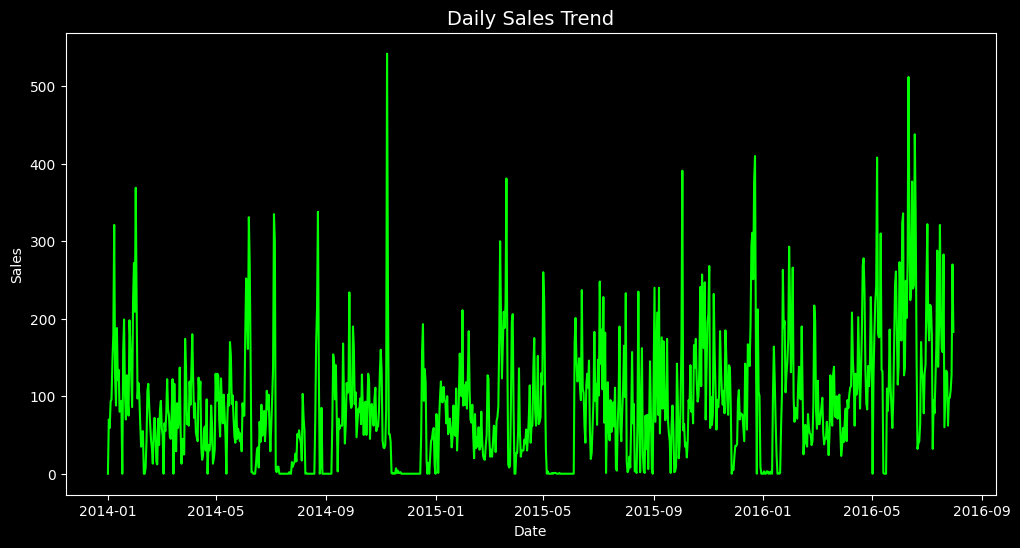

In [9]:

# Visualizing the target variable over time helps understand:
# - trending behavior,seasonality,spikes and dips

plt.figure(figsize=(12,6))
plt.plot(df['ds'], df['y'], color='lime')
plt.title('Daily Sales Trend', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()


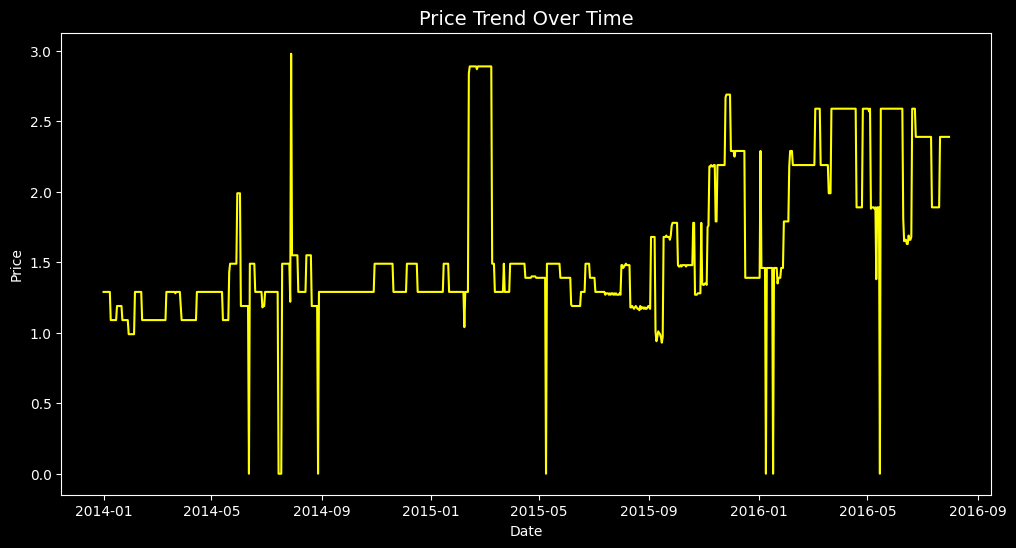

In [10]:
# Visualizing price that will help identify elasticity

plt.figure(figsize=(12,6))
plt.plot(df['ds'], df['price'], color='yellow')
plt.title('Price Trend Over Time', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


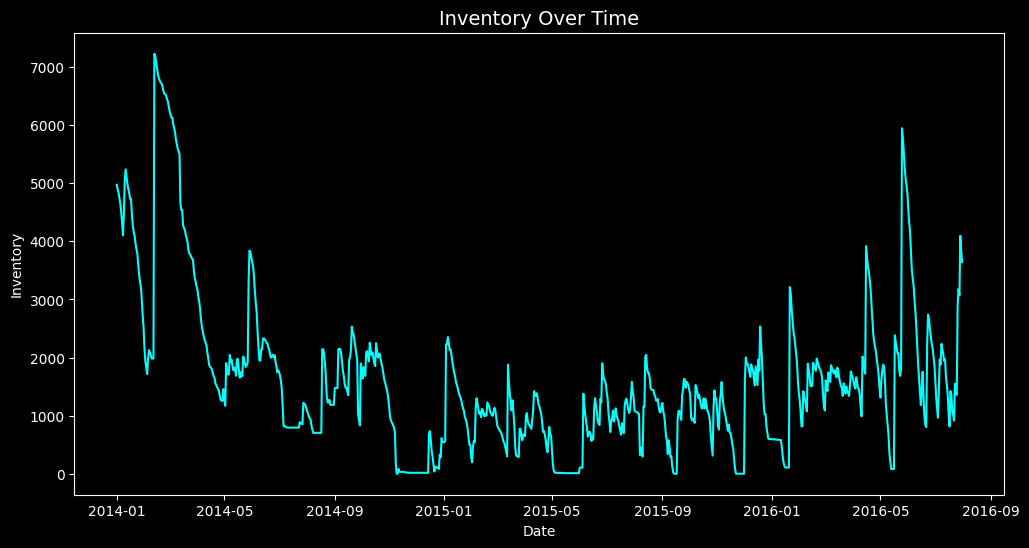

In [12]:
# Checking inventory visually reveals supply-side issues.

plt.figure(figsize=(12,6))
plt.plot(df['ds'], df['inventory'], color='cyan')
plt.title('Inventory Over Time', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Inventory')
plt.show()


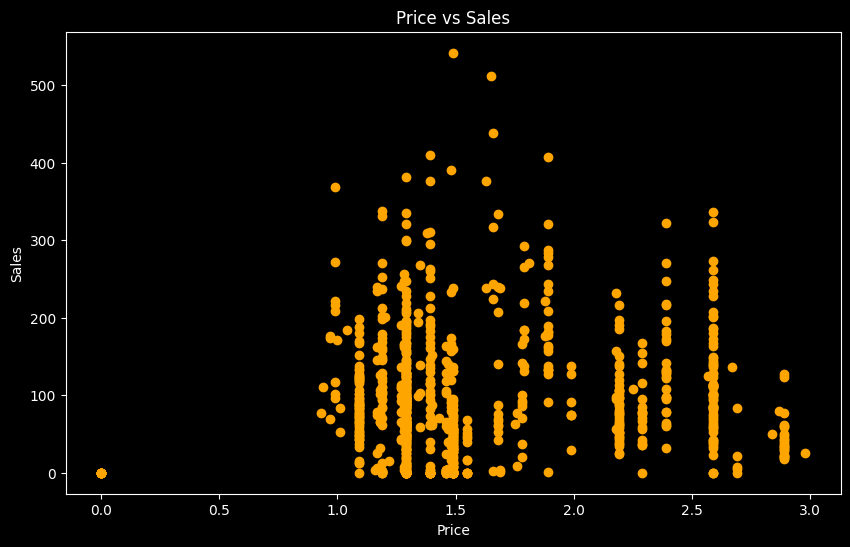

In [13]:
# Price elasticity: how much sales drop when price increases.

plt.figure(figsize=(10,6))
plt.scatter(df['price'], df['y'], c='orange')
plt.title('Price vs Sales')
plt.xlabel('Price')
plt.ylabel('Sales')
plt.show()


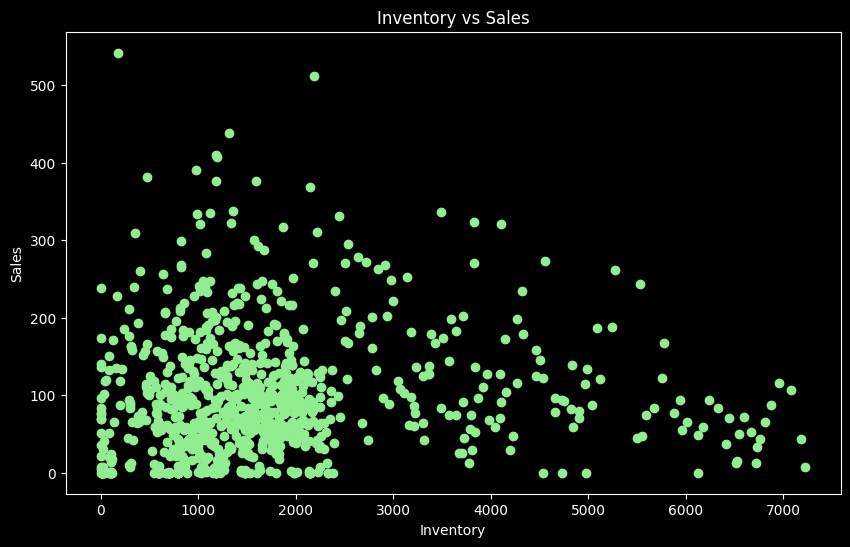

In [14]:
# Relationship between stock levels and sales performance.

plt.figure(figsize=(10,6))
plt.scatter(df['inventory'], df['y'], c='lightgreen')
plt.title('Inventory vs Sales')
plt.xlabel('Inventory')
plt.ylabel('Sales')
plt.show()


In [15]:
# To properly measure model accuracy, we hold out 90 days of data
# and use the remaining for training.

horizon = 90
train = df.iloc[:-horizon]
test = df.iloc[-horizon:]


In [16]:
#model training

model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model.add_regressor('inventory')
model.add_regressor('price')

model.fit(train)


20:52:01 - cmdstanpy - INFO - Chain [1] start processing
20:52:02 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
# forecasting exactly 90 days to match the test set for evaluation.

future = model.make_future_dataframe(periods=horizon)
future = future.merge(df[['ds','inventory','price']], on='ds', how='left')
future[['inventory','price']] = future[['inventory','price']].ffill()

forecast = model.predict(future)


In [18]:
# MAE and RMSE for the accuracy

pred_test = forecast.set_index('ds').loc[test['ds']]

mae = mean_absolute_error(test['y'], pred_test['yhat'])
rmse = np.sqrt(mean_squared_error(test['y'], pred_test['yhat']))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 82.17
RMSE: 106.09


In [19]:
# This forecast to be exported to Power BI.

model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model.add_regressor('inventory')
model.add_regressor('price')
model.fit(df)

future_full = model.make_future_dataframe(periods=90)
future_full = future_full.merge(df[['ds','inventory','price']], on='ds', how='left')
future_full[['inventory','price']] = future_full[['inventory','price']].ffill()

forecast_full = model.predict(future_full)


20:52:57 - cmdstanpy - INFO - Chain [1] start processing
20:52:58 - cmdstanpy - INFO - Chain [1] done processing


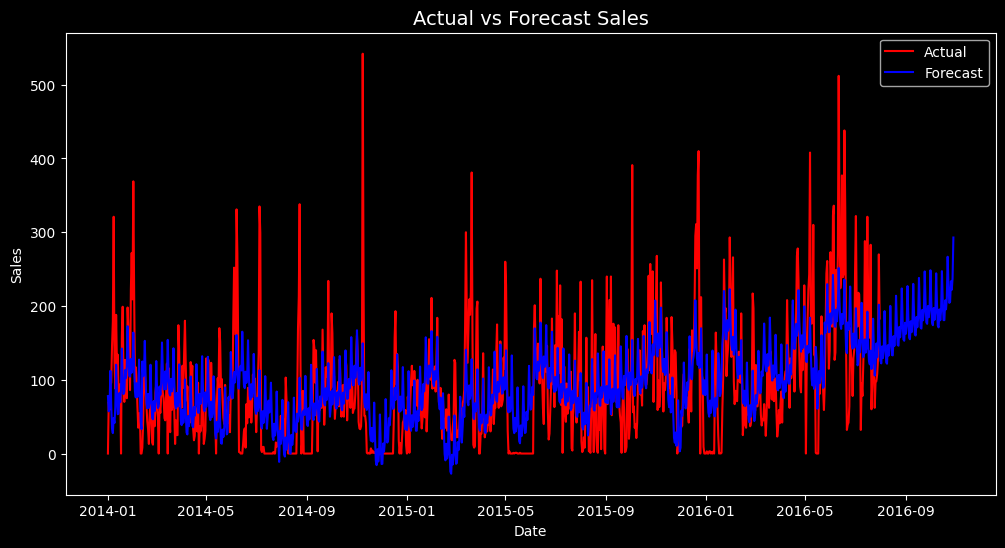

In [20]:
# chart for the report & Power BI.

plt.figure(figsize=(12,6))
plt.plot(df['ds'], df['y'], label='Actual', color='red')
plt.plot(forecast_full['ds'], forecast_full['yhat'], label='Forecast', color='blue')
plt.title('Actual vs Forecast Sales', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


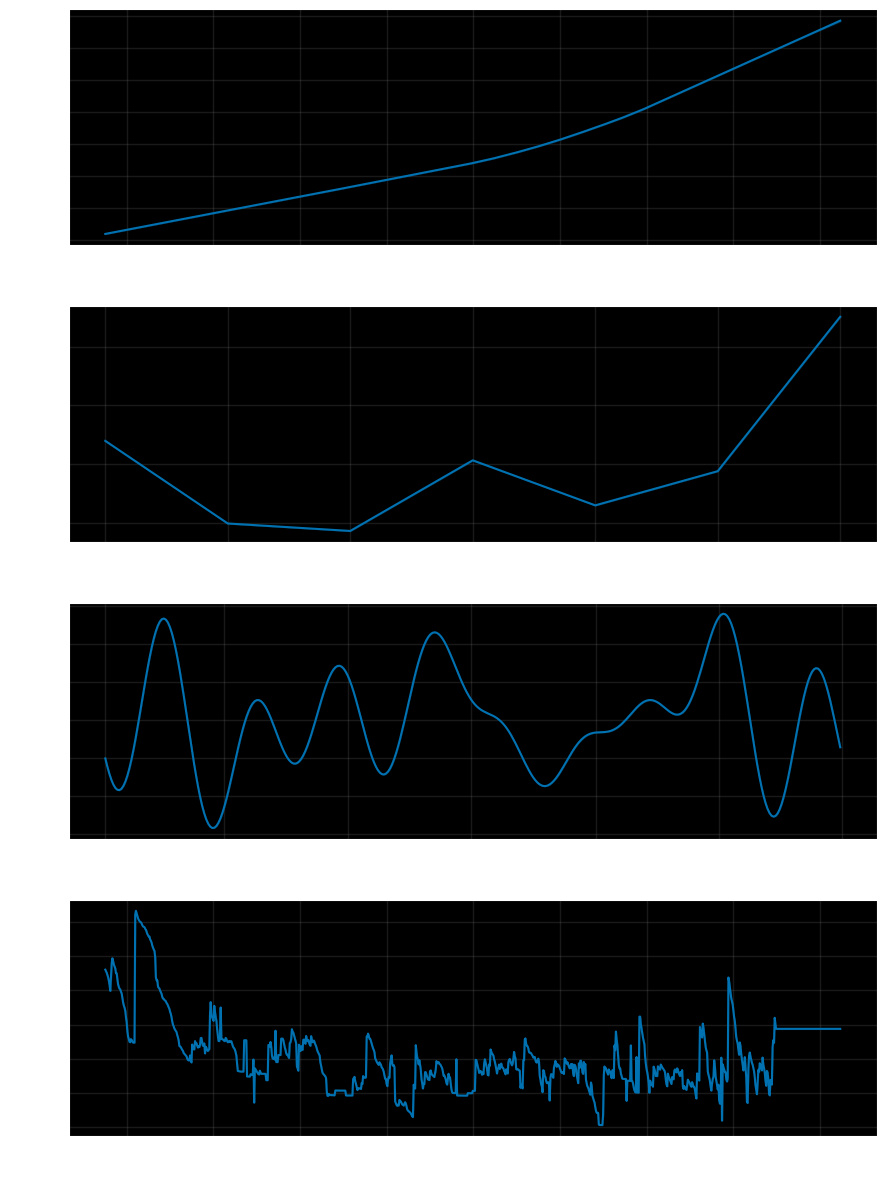

In [21]:
# The plot for Trend curve, Weekly seasonality and Yearly seasonality

model.plot_components(forecast_full)
plt.show()


In [22]:
# Power BI needs these CSV files for the dashboard.

df.to_csv('Cleaned_Actual.csv', index=False)
forecast_full[['ds','yhat','yhat_lower','yhat_upper']].to_csv('forecast_output.csv', index=False)

print("Files exported successfully.")


Files exported successfully.
